In [18]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [8]:
df = pd.read_csv("urgence_clean.csv")

# suppression de tous les NaN (pas le plus recommandé mais le plus rapide)
df = df.dropna()

# convertir la colonne de la cible (target : Duree_totale_heure) en minutes
df["Duree_totale_heure"]=pd.to_timedelta(df.Duree_totale_heure) #convertir dans le type time la cible
df["TotalMin"] = df["Duree_totale_heure"].dt.total_seconds()/60 #convertir en min pour avoir une variable continue et utiliser un modèle de régréssion linéaire
df.drop(columns=["Duree_totale_heure"]) #suppression de ma cible en heure inutile

# suppression de la colonne Unnamed: 0
df = df.drop(columns=["Unnamed: 0"])

# suppression de la colonne Date
df = df.drop(columns=["Date_Heure_Entree_Sejour",
                         "Date_Heure_PEC_IOA",
                         "Date_Heure_PEC_MED", 
                         "Date_Heure_Sortie_Urgences", 
                        "Delai_entree_IOA_heure",
                         "Delai_IOA_MED_heure",
                         "Delai_entree_MED_heure",
                         "Delai_MED_sortie_heure",
                         "Duree_totale_heure"])



In [10]:
# encodage des variables catégorielles
categorical_columns = df.select_dtypes(include=['object']).columns

# Encoder les variables catégorielles
for col in categorical_columns:
    df[col], _ = pd.factorize(df[col])


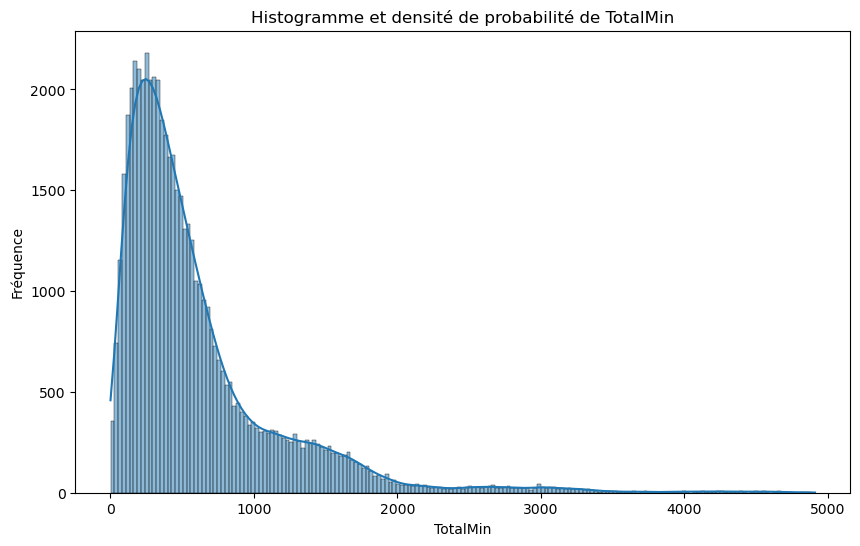

In [28]:
# Supprimer les valeurs supérieures à 50000 dans la colonne 'TotalMin'
df = df[df['TotalMin'] <= 5000]

# Afficher la densité de probabilité et l'histogramme pour la colonne 'TotalMin'
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalMin'], kde=True)
plt.xlabel('TotalMin')
plt.ylabel('Fréquence')
plt.title('Histogramme et densité de probabilité de TotalMin')
plt.show()

In [26]:
# Séparer la target (TotalMin) des features (caractéristiques)
X = df.drop(columns=['TotalMin'])  # Toutes les colonnes sauf 'TotalMin' comme features
y = df['TotalMin']  # La colonne 'TotalMin' comme cible (target)

# Séparer les données en train (80%) et test (20%) sans mélanger (shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Instancier le modèle RandomForestRegressor avec les hyperparamètres
rf_model = RandomForestRegressor(
    n_estimators=100,              # Nombre d'arbres
    max_depth=10,                  # Profondeur maximale des arbres
    max_features='sqrt',           # Nombre de caractéristiques à utiliser par split (ici 'sqrt')
    min_samples_split=2,           # Nombre minimum d'échantillons pour diviser un noeud
    min_samples_leaf=1,            # Nombre minimum d'échantillons dans une feuille
    n_jobs=-1,                     # Utiliser tous les cœurs de processeur
    random_state=42                # Fixer la graine pour la reproductibilité
)

# Entraîner le modèle sur les données d'entraînement
rf_model.fit(X_train, y_train)

# Prédictions sur l'ensemble d'entraînement
y_train_pred = rf_model.predict(X_train)

# Prédictions sur l'ensemble de test
y_test_pred = rf_model.predict(X_test)

# Calcul du R^2 pour l'ensemble d'entraînement
r2_train = r2_score(y_train, y_train_pred)
print(f"R^2 pour l'ensemble d'entraînement: {r2_train}")

# Calcul du R^2 pour l'ensemble de test
r2_test = r2_score(y_test, y_test_pred)
print(f"R^2 pour l'ensemble de test: {r2_test}")

R^2 pour l'ensemble d'entraînement: 0.9290899877936631
R^2 pour l'ensemble de test: 0.9008583594503593


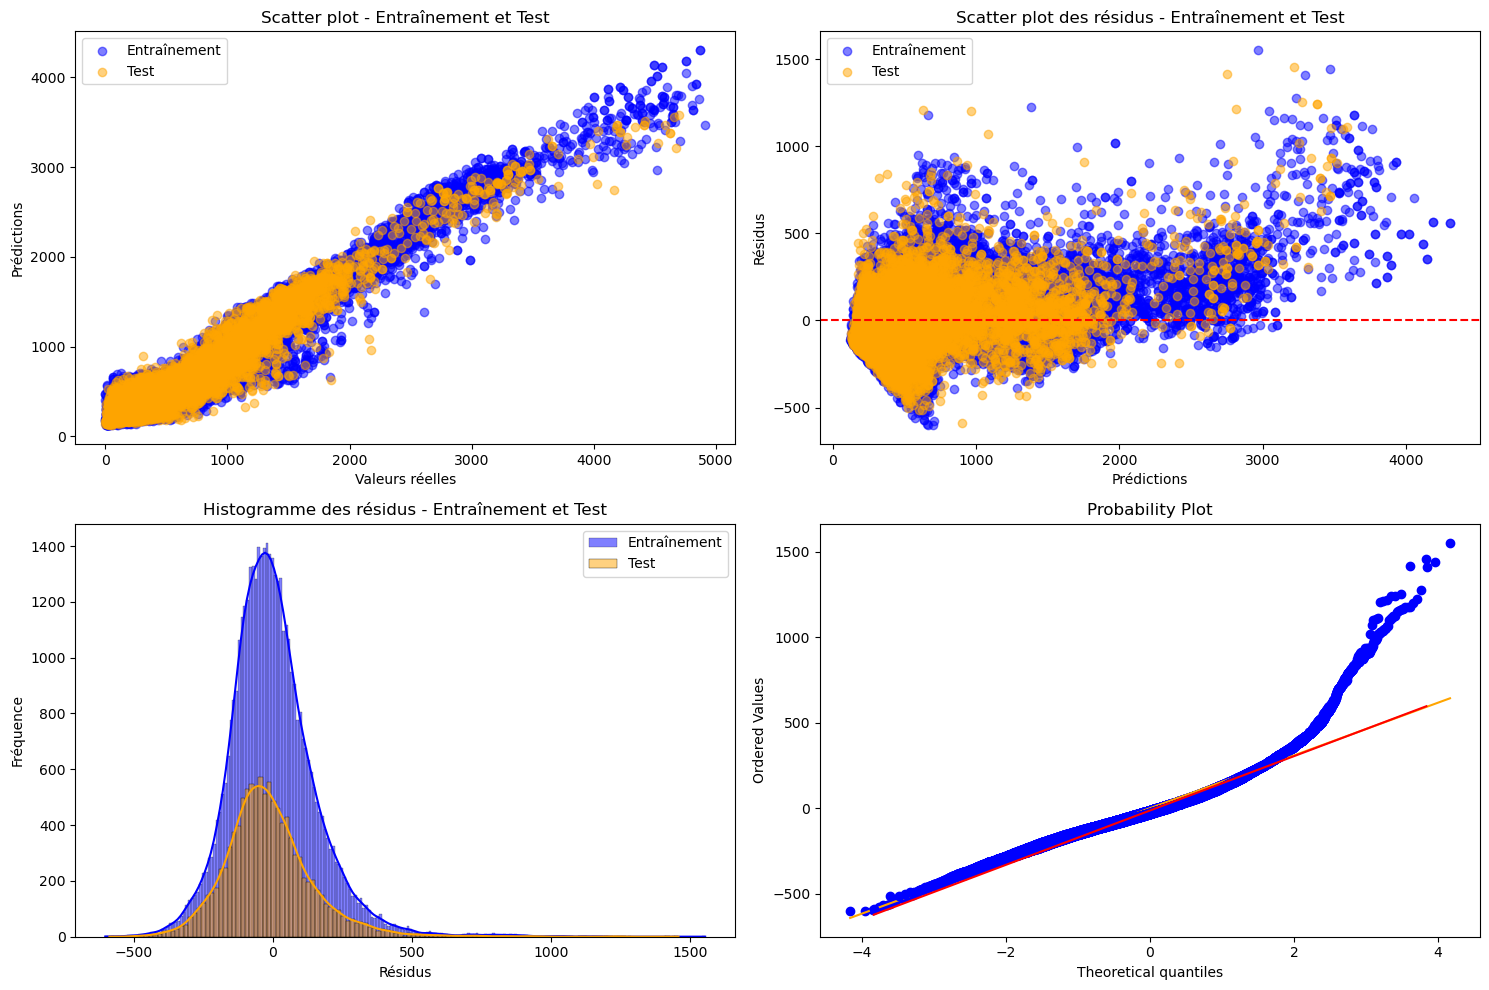

In [27]:
# Calcul des résidus
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Création de la figure et des axes
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Scatter plot combiné pour l'ensemble d'entraînement et de test
axs[0, 0].scatter(y_train, y_train_pred, alpha=0.5, label='Entraînement', color='blue')
axs[0, 0].scatter(y_test, y_test_pred, alpha=0.5, label='Test', color='orange')
axs[0, 0].plot([min(y_train + y_test), max(y_train + y_test)], [min(y_train + y_test), max(y_train + y_test)], color='red')  # Ligne y=x
axs[0, 0].set_xlabel('Valeurs réelles')
axs[0, 0].set_ylabel('Prédictions')
axs[0, 0].set_title('Scatter plot - Entraînement et Test')
axs[0, 0].legend()

# Scatter plot des résidus
axs[0, 1].scatter(y_train_pred, residuals_train, alpha=0.5, label='Entraînement', color='blue')
axs[0, 1].scatter(y_test_pred, residuals_test, alpha=0.5, label='Test', color='orange')
axs[0, 1].axhline(y=0, color='red', linestyle='--')
axs[0, 1].set_xlabel('Prédictions')
axs[0, 1].set_ylabel('Résidus')
axs[0, 1].set_title('Scatter plot des résidus - Entraînement et Test')
axs[0, 1].legend()

# Histogramme des résidus
sns.histplot(residuals_train, kde=True, color='blue', label='Entraînement', alpha=0.5, ax=axs[1, 0])
sns.histplot(residuals_test, kde=True, color='orange', label='Test', alpha=0.5, ax=axs[1, 0])
axs[1, 0].set_xlabel('Résidus')
axs[1, 0].set_ylabel('Fréquence')
axs[1, 0].set_title('Histogramme des résidus - Entraînement et Test')
axs[1, 0].legend()

# QQ-plot des résidus
stats.probplot(residuals_train, dist="norm", plot=axs[1, 1])
axs[1, 1].set_title('QQ-plot des résidus - Entraînement')
stats.probplot(residuals_test, dist="norm", plot=axs[1, 1])
axs[1, 1].get_lines()[1].set_color('orange')  # Changer la couleur de la ligne de test

plt.tight_layout()
plt.show()